# Cell type annotation prediction - Jansky & Westerhout


In this notebook, an [scGPT](https://www.nature.com/articles/s41592-024-02201-0) model is used to predict a cell type annotation with a given gene expression profile.

This follows the tutorial from scGPT [here](https://github.com/bowang-lab/scGPT/blob/main/tutorials/Tutorial_Annotation.ipynb), but instead of fine-tuning the entire model, a smaller neural network is trained, using the embeddings of the gene expressions as inputs, to make a prediction.

The same approach is made with the [Geneformer](https://www.nature.com/articles/s41586-023-06139-9.epdf?sharing_token=u_5LUGVkd3A8zR-f73lU59RgN0jAjWel9jnR3ZoTv0N2UB4yyXENUK50s6uqjXH69sDxh4Z3J4plYCKlVME-W2WSuRiS96vx6t5ex2-krVDS46JkoVvAvJyWtYXIyj74pDWn_DutZq1oAlDaxfvBpUfSKDdBPJ8SKlTId8uT47M%3D) model and the results are compared against each other.

This approach greatly reduces time and complexity.

In [1]:
#!pip3 install helical
#!conda install -c conda-forge louvain
#!pip3 install datasets --upgrade

In [1]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import anndata as ad
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from scipy.sparse import lil_matrix
import torch.optim as optim
from helical.models.scgpt import scGPT, scGPTConfig
from helical.models.geneformer import Geneformer, GeneformerConfig
from copy import deepcopy
from torch.nn.functional import one_hot
import scanpy as sc

  from .autonotebook import tqdm as notebook_tqdm



In [152]:
filename_root_ref = "Fskin_obj_2_4_1_webatlas"
filename= filename_root_ref + ".h5ad"
root_filename_target = "250407_kr250331a_10k_integrated-cca"
filename_target = root_filename_target + ".h5ad"
ref_meta_colname = "annotation_fine"
filename_out_predictions = root_filename_target + "celltype_preds.csv"
sample_id = "sanger_id"
sample_id_target = "HTO_maxID"
predictions_meta_name = "cell_type_predictions"

In [3]:
# Define categories of interest (fibroblast example)
categories_of_interest = [
    "CCL19+ fibroblast",
    "FRZB+ early fibroblast",
    "HOXC5+ early fibroblast",
    "Myofibroblasts",
    "PEAR1+ fibroblast",
    "WNT2+ fibroblast",
]

Fine-tuning data: Jansky

In [7]:
# Load fine-tuning data
adata = sc.read_h5ad(filename)


In [8]:
# Seurat to AnnData conversion can be tricky. Ensure that the raw counts are properly assigned. 
print(adata.X)
print(adata.raw.X)

  (0, 30)	1.887726068496704
  (0, 59)	1.0536537170410156
  (0, 62)	1.5552399158477783
  (0, 86)	1.887726068496704
  (0, 97)	1.0536537170410156
  (0, 104)	1.0536537170410156
  (0, 170)	2.5021462440490723
  (0, 184)	1.0536537170410156
  (0, 208)	1.0536537170410156
  (0, 216)	1.0536537170410156
  (0, 219)	2.336073637008667
  (0, 234)	1.0536537170410156
  (0, 279)	1.0536537170410156
  (0, 282)	1.0536537170410156
  (0, 291)	1.0536537170410156
  (0, 297)	1.5552399158477783
  (0, 355)	1.0536537170410156
  (0, 403)	1.0536537170410156
  (0, 407)	1.0536537170410156
  (0, 438)	1.0536537170410156
  (0, 439)	1.887726068496704
  (0, 470)	1.0536537170410156
  (0, 474)	1.0536537170410156
  (0, 492)	1.887726068496704
  (0, 500)	3.0703396797180176
  :	:
  (432168, 36350)	0.7752326726913452
  (432168, 36351)	0.7752326726913452
  (432168, 36378)	2.082758903503418
  (432168, 36401)	3.6500115394592285
  (432168, 36407)	1.206627607345581
  (432168, 36411)	0.7752326726913452
  (432168, 36412)	0.77523267269134

In [ ]:
mask = adata.obs[ref_meta_colname].isin(categories_of_interest)
print(f"Number of categories of interest (-related) cells: {mask.sum()}")



Number of fibroblast(-related) cells: 142862


In [10]:
# Only copy subset if needed
adata = adata[mask].copy()

In [11]:
# Copy raw counts to adata.X if necessary
adata.X = adata.raw.X.copy()
adata.var["gene_name"] = adata.var_names # "Data must have the provided key 'gene_name' in its 'var' section to be processed by the Helical RNA model."

In [12]:
adata.obs

,sanger_id,chemistry,donor,gender,pcw,sorting,sample,chemistry_sorting,index,doublet_scores,...,mt_outlier,QC,S_score,G2M_score,phase,joint_annotation_20220202,fig1b_annotation_v2,annotation_fine,annotation_verybroad,annotation_broad
index1,,,,,,,,,,,,,,,,,,,,,
AACCATGAGGTGCTTT-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8.0,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,AACCATGAGGTGCTTT-1-4834STDY7002879,0.024902,...,False,Pass,-0.116821,-0.093996,G1,NaN,NaN,Myofibroblasts,Dermal stroma,Fibroblast
AACTTTCCACGAAGCA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8.0,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,AACTTTCCACGAAGCA-1-4834STDY7002879,0.002784,...,False,Pass,-1.228558,-1.383166,G1,NaN,NaN,Myofibroblasts,Dermal stroma,Fibroblast
AAGGTTCGTGTAACGG-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8.0,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,AAGGTTCGTGTAACGG-1-4834STDY7002879,0.013524,...,False,Pass,1.092142,-0.562466,S,NaN,NaN,WNT2+ fibroblast,Dermal stroma,Fibroblast
ACACCCTGTCGTTGTA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8.0,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,ACACCCTGTCGTTGTA-1-4834STDY7002879,0.004397,...,False,Pass,-1.050037,-0.746950,G1,WNT2+ fibroblast,Fibroblast,WNT2+ fibroblast,Dermal stroma,Fibroblast
ACATACGTCGAATGCT-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8.0,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,ACATACGTCGAATGCT-1-4834STDY7002879,0.004397,...,False,Pass,-1.254865,-1.154951,G1,NaN,NaN,WNT2+ fibroblast,Dermal stroma,Fibroblast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTCTGGTCG-1-HCA_rFSKI14539501,HCA_rFSKI14539501,SC5P-R2,F221,female,14.0,CD45NCD34P,NaN,SC5P-R2_CD45NCD34P,TTTGTCAGTCTGGTCG-1-HCA_rFSKI14539501,0.011840,...,False,Pass,-0.551224,-0.623907,G1,NaN,NaN,WNT2+ fibroblast,Dermal stroma,Fibroblast
TTTGTCAGTTCATGGT-1-HCA_rFSKI14539501,HCA_rFSKI14539501,SC5P-R2,F221,female,14.0,CD45NCD34P,NaN,SC5P-R2_CD45NCD34P,TTTGTCAGTTCATGGT-1-HCA_rFSKI14539501,0.131626,...,False,Pass,0.446200,0.143775,S,NaN,NaN,HOXC5+ early fibroblast,Dermal stroma,Fibroblast
TTTGTCATCACAGTAC-1-HCA_rFSKI14539501,HCA_rFSKI14539501,SC5P-R2,F221,female,14.0,CD45NCD34P,NaN,SC5P-R2_CD45NCD34P,TTTGTCATCACAGTAC-1-HCA_rFSKI14539501,0.071668,...,False,Pass,-0.528307,-0.478350,G1,NaN,NaN,WNT2+ fibroblast,Dermal stroma,Fibroblast


Randomly choose approx. 20% of patients to leave out for test set (final evaluation).

In [ ]:
import random

  # unique patient ids
unseen_patients = random.sample(list(set(adata.obs[sample_id])), 3)
print(unseen_patients)

adata_evaluation = adata[adata.obs[sample_id].isin(unseen_patients)]
adata_finetuning  = adata[~adata.obs[sample_id].isin(unseen_patients)]


['FCAImmP7579224', 'FCAImmP7803027', 'WS_wEMB13942153']


We are interested in the names of the cells we want to predict. They are saved in `adata.obs[ref_meta_colname]`.

Additionally, we need to know how many distinct cell types/classes we have.

In [15]:
adata_finetuning.obs


,sanger_id,chemistry,donor,gender,pcw,sorting,sample,chemistry_sorting,index,doublet_scores,...,mt_outlier,QC,S_score,G2M_score,phase,joint_annotation_20220202,fig1b_annotation_v2,annotation_fine,annotation_verybroad,annotation_broad
index1,,,,,,,,,,,,,,,,,,,,,
AACCATGAGGTGCTTT-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8.0,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,AACCATGAGGTGCTTT-1-4834STDY7002879,0.024902,...,False,Pass,-0.116821,-0.093996,G1,NaN,NaN,Myofibroblasts,Dermal stroma,Fibroblast
AACTTTCCACGAAGCA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8.0,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,AACTTTCCACGAAGCA-1-4834STDY7002879,0.002784,...,False,Pass,-1.228558,-1.383166,G1,NaN,NaN,Myofibroblasts,Dermal stroma,Fibroblast
AAGGTTCGTGTAACGG-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8.0,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,AAGGTTCGTGTAACGG-1-4834STDY7002879,0.013524,...,False,Pass,1.092142,-0.562466,S,NaN,NaN,WNT2+ fibroblast,Dermal stroma,Fibroblast
ACACCCTGTCGTTGTA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8.0,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,ACACCCTGTCGTTGTA-1-4834STDY7002879,0.004397,...,False,Pass,-1.050037,-0.746950,G1,WNT2+ fibroblast,Fibroblast,WNT2+ fibroblast,Dermal stroma,Fibroblast
ACATACGTCGAATGCT-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8.0,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,ACATACGTCGAATGCT-1-4834STDY7002879,0.004397,...,False,Pass,-1.254865,-1.154951,G1,NaN,NaN,WNT2+ fibroblast,Dermal stroma,Fibroblast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTCTGGTCG-1-HCA_rFSKI14539501,HCA_rFSKI14539501,SC5P-R2,F221,female,14.0,CD45NCD34P,NaN,SC5P-R2_CD45NCD34P,TTTGTCAGTCTGGTCG-1-HCA_rFSKI14539501,0.011840,...,False,Pass,-0.551224,-0.623907,G1,NaN,NaN,WNT2+ fibroblast,Dermal stroma,Fibroblast
TTTGTCAGTTCATGGT-1-HCA_rFSKI14539501,HCA_rFSKI14539501,SC5P-R2,F221,female,14.0,CD45NCD34P,NaN,SC5P-R2_CD45NCD34P,TTTGTCAGTTCATGGT-1-HCA_rFSKI14539501,0.131626,...,False,Pass,0.446200,0.143775,S,NaN,NaN,HOXC5+ early fibroblast,Dermal stroma,Fibroblast
TTTGTCATCACAGTAC-1-HCA_rFSKI14539501,HCA_rFSKI14539501,SC5P-R2,F221,female,14.0,CD45NCD34P,NaN,SC5P-R2_CD45NCD34P,TTTGTCATCACAGTAC-1-HCA_rFSKI14539501,0.071668,...,False,Pass,-0.528307,-0.478350,G1,NaN,NaN,WNT2+ fibroblast,Dermal stroma,Fibroblast


In [16]:
adata_finetuning.var

,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection,gene_name
MIR1302-2HG,False,0.000073,0.070344,-0.146171,0,False,MIR1302-2HG
FAM138A,False,0.000000,0.000000,0.000000,0,False,FAM138A
OR4F5,False,0.000003,0.003471,-0.007656,0,False,OR4F5
AL627309.1,False,0.001279,0.523715,-0.424807,0,False,AL627309.1
AL627309.3,False,0.000054,0.077640,-0.164783,0,False,AL627309.3
...,...,...,...,...,...,...,...
AC141272.1,False,0.000045,0.025926,-0.007041,0,False,AC141272.1
AC023491.2,False,0.000037,-0.008399,-0.135764,0,False,AC023491.2
AC007325.1,False,0.000283,0.085710,-0.271996,0,False,AC007325.1
AC007325.4,False,0.022282,0.913404,-0.002196,7,False,AC007325.4


In [80]:
# get labels: the celltype
num_types = adata_finetuning.obs[ref_meta_colname].unique().shape[0]
id2type = dict(enumerate(adata_finetuning.obs[ref_meta_colname].astype("category").cat.categories))

celltypes_labels = np.array(adata_finetuning.obs[ref_meta_colname].tolist())

This is all summarized in this dictionary:

In [81]:
id2type

{0: 'CCL19+ fibroblast',
 1: 'FRZB+ early fibroblast',
 2: 'HOXC5+ early fibroblast',
 3: 'Myofibroblasts',
 4: 'PEAR1+ fibroblast',
 5: 'WNT2+ fibroblast'}

Use the Helical package to get the embeddings of the gene expression profile.

The only thing we need to specify is the column containing the names of the genes. (`gene_name` in this case)

The resulting embeddings are the input features `x` for our smaller NN model.

# scGPT

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Configure and initialize the scGPT model
scgpt_config = scGPTConfig(batch_size=50, device=device)
scgpt = scGPT(configurer = scgpt_config)

# Process the data for the scGPT model
Normalize_SubsetHighlyVariable = False # This logic is also connected to processing the left out data (adata_unseen).

if Normalize_SubsetHighlyVariable:
    data_processed = scgpt.process_data(adata_finetuning, gene_names = "gene_name", fine_tuning=True)
else:
    data_processed = scgpt.process_data(adata_finetuning, gene_names = "gene_name")

# Get embeddings
x_scgpt = scgpt.get_embeddings(data_processed)
x_scgpt.shape

  warnings.warn(

INFO:helical.models.scgpt.model:Model finished initializing.
INFO:helical.models.scgpt.model:'scGPT' model is in 'eval' mode, on device 'cuda' with embedding mode 'cell'.
INFO:helical.models.scgpt.model:Processing data for scGPT.
  adata.obs["total_counts"] = adata.X.sum(axis=1)

INFO:helical.models.scgpt.model:Filtering out 12316 genes to a total of 24285 genes with an ID in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Successfully processed the data for scGPT.
INFO:helical.models.scgpt.model:Started getting embeddings:
  torch.cuda.amp.autocast(enabled=True),

Embedding cells: 100%|██████████| 2776/2776 [20:56<00:00,  2.21it/s]
INFO:helical.models.scgpt.model:Finished getting embeddings.


(138774, 512)

With the input features, we also need the corresponding labels `y`.

They correspond to the cell type labels.

As we have a categorical prediction, we transform the cell type labels to integer labels to work with CrossEntropyLoss later.

In [82]:
y = celltypes_labels

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_encoded = one_hot(torch.tensor(y_encoded),num_types).float()

In [83]:
freq = pd.Series(y).value_counts()
freq

WNT2+ fibroblast           60014
HOXC5+ early fibroblast    29166
Myofibroblasts             20205
PEAR1+ fibroblast          16870
FRZB+ early fibroblast     12019
CCL19+ fibroblast            500
Name: count, dtype: int64

In [158]:
#np.save( filename_root_ref + "x_scgpt",x_scgpt)
x_scgpt_reloaded = np.load(filename_root_ref + "x_scgpt.npy")
#np.array_equal(x_scgpt_reloaded, x_scgpt, equal_nan=True)

True

## Define and train the model

In [84]:
input_shape = 512

# Define the model architecture
head_model = nn.Sequential(
    nn.Linear(input_shape, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 32),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(32, num_types)
    )

print(head_model)

Sequential(
  (0): Linear(in_features=512, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=128, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.4, inplace=False)
  (6): Linear(in_features=32, out_features=6, bias=True)
)


In [85]:
def train_model(model: nn.Sequential,
                X_train: torch.Tensor,
                y_train: torch.Tensor,
                X_val: torch.Tensor,
                y_val: torch.Tensor,
                optimizer = optim.Adam,
                loss_fn = nn.CrossEntropyLoss(),
                num_epochs = 100,
                batch = 64):

    # Create DataLoader for batching
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)

    # Validation dataset
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

    # Ensure model is in training mode
    model.train()

    for epoch in range(num_epochs):
        for batch_X, batch_y in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch_X)

            # Compute loss
            loss = loss_fn(outputs, batch_y)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase (optional)
        model.eval()
        with torch.no_grad():
            val_losses = []
            for val_X, val_y in val_loader:
                val_outputs = model(val_X)
                val_loss = loss_fn(val_outputs, val_y)
                val_losses.append(val_loss.item())

            print(f"Epoch {epoch+1}, Validation Loss: {sum(val_losses)/len(val_losses)}")

        # Set back to training mode for next epoch
        model.train()

    model.eval()
    return model

In [86]:
X_train, X_test, y_train, y_test = train_test_split(x_scgpt, y_encoded, test_size=0.1, random_state=42)

head_model_scgpt = deepcopy(head_model)
head_model_scgpt = train_model(head_model_scgpt,
                               torch.from_numpy(X_train),
                               y_train,
                               torch.from_numpy(X_test),
                               y_test,
                               optim.Adam(head_model_scgpt.parameters(), lr=0.001),
                               nn.CrossEntropyLoss())

Epoch 1, Validation Loss: 0.5530347295345799
Epoch 2, Validation Loss: 0.5011269825120126
Epoch 3, Validation Loss: 0.4808240986090102
Epoch 4, Validation Loss: 0.46306792959090204
Epoch 5, Validation Loss: 0.45687249879683217
Epoch 6, Validation Loss: 0.44192953421498227
Epoch 7, Validation Loss: 0.4371320389657526
Epoch 8, Validation Loss: 0.43448919483593534
Epoch 9, Validation Loss: 0.4219775703920197
Epoch 10, Validation Loss: 0.42410500752761066
Epoch 11, Validation Loss: 0.4260746596320983
Epoch 12, Validation Loss: 0.41428879171197863
Epoch 13, Validation Loss: 0.411432097790428
Epoch 14, Validation Loss: 0.40866277226105263
Epoch 15, Validation Loss: 0.4095060246468689
Epoch 16, Validation Loss: 0.4046817394445569
Epoch 17, Validation Loss: 0.405098573884107
Epoch 18, Validation Loss: 0.40752381340424587
Epoch 19, Validation Loss: 0.3969245396451467
Epoch 20, Validation Loss: 0.4036227626047926
Epoch 21, Validation Loss: 0.4019621412188227
Epoch 22, Validation Loss: 0.39583674

In [87]:
# Predictions on the test set and ground truth
predictions_nn = head_model_scgpt(torch.Tensor(X_test))
y_pred = np.array(torch.argmax(predictions_nn, dim=1))
y_true = np.array(y_test.argmax(axis=1))

## Present the results
- on the test set and,
- a separate, unseen evaluation set

In [88]:
def get_evaluations(name_data_set, y_true, y_pred) -> dict:
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average='macro')
  f1 = f1_score(y_true, y_pred, average='macro')
  recall = recall_score(y_true, y_pred, average='macro')
  print(f"{name_data_set} accuracy: {(accuracy*100):.1f}%")
  print(f"{name_data_set} precision: {(precision*100):.1f}%")
  print(f"{name_data_set} f1: {(f1*100):.1f}%")
  print(f"{name_data_set} recall: {(recall*100):.1f}%")
  return {
      "accuracy": accuracy,
      "precision": precision,
      "f1": f1,
      "recall": recall,
  }

In [89]:
get_evaluations("Test set", y_true, y_pred)

Test set accuracy: 87.3%
Test set precision: 90.5%
Test set f1: 87.8%
Test set recall: 85.6%


{'accuracy': 0.8729644040928087,
 'precision': 0.904924307233809,
 'f1': 0.87779419234381,
 'recall': 0.8557815133970598}

In [73]:
get_evaluations_2("Test set", y_true, y_pred)

Test set accuracy: 87.52%
Test set precision: 87.59%
Test set recall: 87.52%
Test set F1: 87.34%


{0: 'CCL19+ fibroblast', 1: 'FRZB+ early fibroblast', 2: 'HOXC5+ early fibroblast', 3: 'Myofibroblasts', 4: 'PEAR1+ fibroblast', 5: 'WNT2+ fibroblast'}


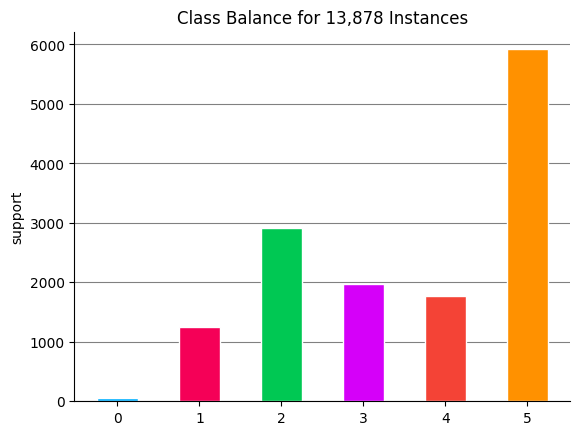

In [90]:
# Visualize class distribution
from sklearn_evaluation import plot
plot.target_analysis(y_true)
print(id2type)

In [ ]:
## Only if you want to forget about zero_devision
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# def get_evaluations_2(name, y_true, y_pred):
#     acc = accuracy_score(y_true, y_pred)
#     prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
#     rec = recall_score(y_true, y_pred, average="weighted", zero_division=0)
#     f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
#     print(f"{name} accuracy: {acc*100:.2f}%")
#     print(f"{name} precision: {prec*100:.2f}%")
#     print(f"{name} recall: {rec*100:.2f}%")
#     print(f"{name} F1: {f1*100:.2f}%")

Load the unseen evaluation set. Two options:

1. Evaluation: Load the left out evaluation set from the finetuning dataset. (with true labels - Jansky)
2. Target: Load the dataset that the predictions will be made on. (no true labels - Westerhout)

In [91]:
final_task = "evaluation" # "evaluation" or "target"
if final_task == "target":
    adata_unseen = sc.read_h5ad(filename_target)
    adata_unseen.X = adata_unseen.raw.X.copy()
    adata_unseen.var["gene_name"] = adata_unseen.var_names # "Data must have the provided key 'gene_name' in its 'var' section to be processed by the Helical RNA model."
elif final_task == "evaluation": 
    adata_unseen = adata_evaluation # AnnData preprocessing was done before the finetuning - evaluation split.
    

In [92]:
# Process the unseen data
if Normalize_SubsetHighlyVariable:
    data_processed = scgpt.process_data(adata_unseen, gene_names = "gene_name", fine_tuning=True)
else:
    data_processed = scgpt.process_data(adata_unseen, gene_names = "gene_name")

# Get embeddings and predictions
x_unseen = scgpt.get_embeddings(data_processed)
predictions_nn_unseen = head_model_scgpt(torch.Tensor(x_unseen))

INFO:helical.models.scgpt.model:Processing data for scGPT.
INFO:helical.models.scgpt.model:Filtering out 12316 genes to a total of 24285 genes with an ID in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Successfully processed the data for scGPT.
INFO:helical.models.scgpt.model:Started getting embeddings:
  torch.cuda.amp.autocast(enabled=True),

Embedding cells: 100%|██████████| 82/82 [00:35<00:00,  2.33it/s]
INFO:helical.models.scgpt.model:Finished getting embeddings.


  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])

  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Unseen evaluation set accuracy: 1.6%
Unseen evaluation set precision: 2.7%
Unseen evaluation set f1: 1.4%
Unseen evaluation set recall: 1.0%
{0: 'CCL19+ fibroblast', 1: 'FRZB+ early fibroblast', 2: 'HOXC5+ early fibroblast', 3: 'Myofibroblasts', 4: 'PEAR1+ fibroblast', 5: 'WNT2+ fibroblast'}


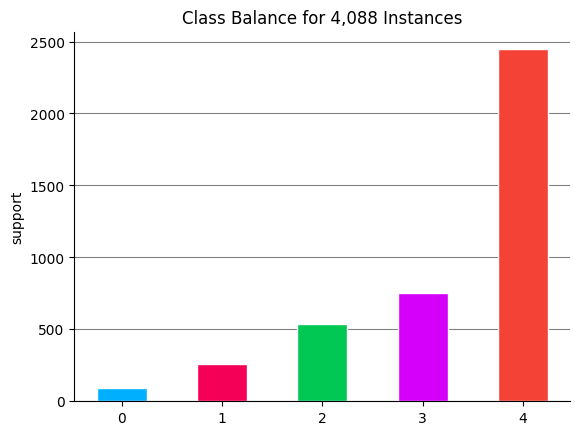

In [ ]:
if final_task == "evaluation":
    y_pred_unseen = np.array(torch.argmax(predictions_nn_unseen, dim=1))
    y_true_unseen = np.array(adata_unseen.obs[ref_meta_colname].astype("category").cat.codes)
    get_evaluations("Unseen evaluation set", y_true_unseen, y_pred_unseen)
    plot.target_analysis(y_true_unseen)
    print(id2type)
elif final_task == "target":
    save_annData_with_predictions = True

    y_pred_unseen = [id2type[prediction] for prediction in np.array(torch.argmax(predictions_nn_unseen, dim=1))]
    if save_annData_with_predictions:
        adata_unseen.obs[predictions_meta_name] = y_pred_unseen
        adata_unseen.obs.to_csv(filename_out_predictions)

    print(adata_unseen.obs)


In [98]:
if final_task == "evaluation":
    num_types = adata_unseen.obs[ref_meta_colname].unique().shape[0]
    id2type_unseen = dict(enumerate(adata_unseen.obs[ref_meta_colname].astype("category").cat.categories))
    print(sorted(id2type_unseen) == sorted(id2type))
    
print(id2type)
print(id2type_unseen)

False
{0: 'CCL19+ fibroblast', 1: 'FRZB+ early fibroblast', 2: 'HOXC5+ early fibroblast', 3: 'Myofibroblasts', 4: 'PEAR1+ fibroblast', 5: 'WNT2+ fibroblast'}
{0: 'FRZB+ early fibroblast', 1: 'HOXC5+ early fibroblast', 2: 'Myofibroblasts', 3: 'PEAR1+ fibroblast', 4: 'WNT2+ fibroblast'}


In [99]:
   
if final_task == "evaluation":
    y_true_unseen = np.array(adata_unseen.obs[ref_meta_colname].tolist())
    y_pred_unseen = [id2type[prediction] for prediction in np.array(torch.argmax(predictions_nn_unseen, dim=1))]

    scgpt_results = get_evaluations("Evaluation set", y_true_unseen, y_pred_unseen)

Evaluation set accuracy: 86.2%
Evaluation set precision: 83.6%
Evaluation set f1: 72.6%
Evaluation set recall: 68.5%


true                     pred                   
FRZB+ early fibroblast   FRZB+ early fibroblast       18
                         HOXC5+ early fibroblast       6
                         Myofibroblasts               10
                         PEAR1+ fibroblast            20
                         WNT2+ fibroblast             36
HOXC5+ early fibroblast  FRZB+ early fibroblast        1
                         HOXC5+ early fibroblast     209
                         Myofibroblasts                1
                         PEAR1+ fibroblast             8
                         WNT2+ fibroblast             43
Myofibroblasts           Myofibroblasts              382
                         PEAR1+ fibroblast            10
                         WNT2+ fibroblast            146
PEAR1+ fibroblast        FRZB+ early fibroblast        1
                         HOXC5+ early fibroblast       1
                         Myofibroblasts               34
                         PEAR1+ fibrobl

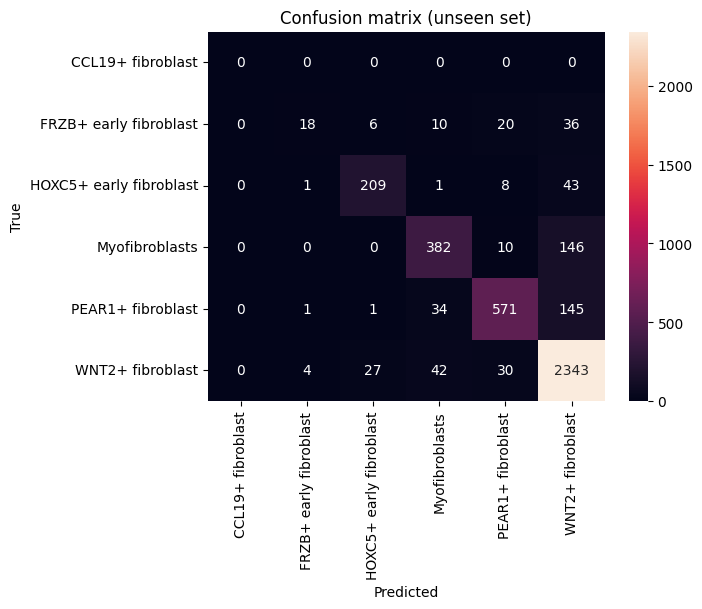

In [102]:
import pandas as pd

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define all possible labels in the correct order
all_labels = list(id2type.values())  # includes CCL19+ fibroblast even if missing

df_eval = pd.DataFrame({
    "true": y_true_unseen,
    "pred": y_pred_unseen
})

print(df_eval.groupby(["true", "pred"]).size())

# Compute confusion matrix, forcing all labels
cm = confusion_matrix(y_true_unseen, y_pred_unseen, labels=all_labels)

# Plot with seaborn, keeping label order
sns.heatmap(cm, annot=True, fmt="d", xticklabels=all_labels, yticklabels=all_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix (unseen set)")
plt.show()

In [79]:
# Unique labels in the training set
train_labels = adata.obs[ref_meta_colname]
print("Training labels:", sorted(train_labels.unique()))

# Unique labels in the unseen set
unseen_labels = adata_unseen.obs[ref_meta_colname]
print("Unseen labels:", sorted(unseen_labels.unique()))

Training labels: ['CCL19+ fibroblast', 'FRZB+ early fibroblast', 'HOXC5+ early fibroblast', 'Myofibroblasts', 'PEAR1+ fibroblast', 'WNT2+ fibroblast']
Unseen labels: ['FRZB+ early fibroblast', 'HOXC5+ early fibroblast', 'Myofibroblasts', 'PEAR1+ fibroblast', 'WNT2+ fibroblast']


In [ ]:
## if you want to work with common_labels only
# common_labels = list(set(train_labels.unique()).intersection(unseen_labels.unique()))
# print("Labels used for evaluation:", sorted(common_labels))

# # Subset training and unseen labels to common labels
# y_true_unseen = adata_unseen.obs[ref_meta_colname].astype("category")
# y_true_unseen = y_true_unseen.cat.set_categories(common_labels).cat.codes.to_numpy()

# y_pred_unseen = np.array(torch.argmax(predictions_nn_unseen, dim=1))

Labels used for evaluation: ['FRZB+ early fibroblast', 'HOXC5+ early fibroblast', 'Myofibroblasts', 'PEAR1+ fibroblast', 'WNT2+ fibroblast']


In [74]:
id2type

train_counts = adata[adata.obs[ref_meta_colname].isin(categories_of_interest)].obs[ref_meta_colname].value_counts()
print(train_counts)

annotation_fine
WNT2+ fibroblast           62460
HOXC5+ early fibroblast    29428
Myofibroblasts             20743
PEAR1+ fibroblast          17622
FRZB+ early fibroblast     12109
CCL19+ fibroblast            500
Name: count, dtype: int64


We should double check that the cell types are mapped to the correct id numbers for both the training data and this new data set.

In [58]:
if final_task == "evaluation":
    num_types = adata_unseen.obs[ref_meta_colname].unique().shape[0]
    id2type_unseen = dict(enumerate(adata_unseen.obs[ref_meta_colname].astype("category").cat.categories))
    print(id2type_unseen == id2type)

    print("Common labels:", sorted(common_labels))
    print("Unseen categories:", list(adata_unseen.obs[ref_meta_colname].astype("category").cat.categories))

False
Common labels: ['FRZB+ early fibroblast', 'HOXC5+ early fibroblast', 'Myofibroblasts', 'PEAR1+ fibroblast', 'WNT2+ fibroblast']
Unseen categories: ['FRZB+ early fibroblast', 'HOXC5+ early fibroblast', 'Myofibroblasts', 'PEAR1+ fibroblast', 'WNT2+ fibroblast']


In [77]:
if final_task == "evaluation":
    num_types = adata_unseen.obs[ref_meta_colname].unique().shape[0]
    id2type_unseen = dict(enumerate(adata_unseen.obs[ref_meta_colname].astype("category").cat.categories))
    print(sorted(id2type_unseen) == sorted(id2type))
    print(id2type_unseen)
    print(id2type)

True
{0: 'FRZB+ early fibroblast', 1: 'HOXC5+ early fibroblast', 2: 'Myofibroblasts', 3: 'PEAR1+ fibroblast', 4: 'WNT2+ fibroblast'}
{0: 'Myofibroblasts', 1: 'FRZB+ early fibroblast', 2: 'PEAR1+ fibroblast', 3: 'HOXC5+ early fibroblast', 4: 'WNT2+ fibroblast'}


In [115]:
# Convert predicted indices to labels safely
y_pred_indices = np.array(torch.argmax(predictions_nn_unseen, dim=1))
y_pred_unseen = []

for idx in y_pred_indices:
    if idx in id2type:
        y_pred_unseen.append(id2type[idx])
    else:
        y_pred_unseen.append("unknown")  # or np.nan


unique_preds = set(y_pred_unseen)
print(unique_preds)


print(unique_trues)

y_pred_unseen


{'Myofibroblasts', 'FRZB+ early fibroblast', 'PEAR1+ fibroblast', 'HOXC5+ early fibroblast', 'WNT2+ fibroblast'}
{'Myofibroblasts', 'FRZB+ early fibroblast', 'PEAR1+ fibroblast', 'HOXC5+ early fibroblast', 'WNT2+ fibroblast'}


['PEAR1+ fibroblast',
 'PEAR1+ fibroblast',
 'WNT2+ fibroblast',
 'PEAR1+ fibroblast',
 'HOXC5+ early fibroblast',
 'WNT2+ fibroblast',
 'PEAR1+ fibroblast',
 'WNT2+ fibroblast',
 'WNT2+ fibroblast',
 'WNT2+ fibroblast',
 'PEAR1+ fibroblast',
 'WNT2+ fibroblast',
 'HOXC5+ early fibroblast',
 'WNT2+ fibroblast',
 'WNT2+ fibroblast',
 'HOXC5+ early fibroblast',
 'PEAR1+ fibroblast',
 'PEAR1+ fibroblast',
 'WNT2+ fibroblast',
 'WNT2+ fibroblast',
 'PEAR1+ fibroblast',
 'PEAR1+ fibroblast',
 'WNT2+ fibroblast',
 'PEAR1+ fibroblast',
 'PEAR1+ fibroblast',
 'WNT2+ fibroblast',
 'WNT2+ fibroblast',
 'WNT2+ fibroblast',
 'WNT2+ fibroblast',
 'HOXC5+ early fibroblast',
 'WNT2+ fibroblast',
 'HOXC5+ early fibroblast',
 'PEAR1+ fibroblast',
 'WNT2+ fibroblast',
 'WNT2+ fibroblast',
 'HOXC5+ early fibroblast',
 'WNT2+ fibroblast',
 'WNT2+ fibroblast',
 'WNT2+ fibroblast',
 'WNT2+ fibroblast',
 'HOXC5+ early fibroblast',
 'WNT2+ fibroblast',
 'WNT2+ fibroblast',
 'WNT2+ fibroblast',
 'PEAR1+ fibrob

In [117]:
unique_trues = set(y_true_unseen)
print(unique_trues)

y_true_unseen

{'Myofibroblasts', 'FRZB+ early fibroblast', 'PEAR1+ fibroblast', 'HOXC5+ early fibroblast', 'WNT2+ fibroblast'}


array(['PEAR1+ fibroblast', 'WNT2+ fibroblast', 'WNT2+ fibroblast', ...,
       'WNT2+ fibroblast', 'PEAR1+ fibroblast', 'Myofibroblasts'],
      dtype='<U23')

In [118]:
if final_task == "evaluation":
    y_true_unseen = np.array(adata_unseen.obs[ref_meta_colname].tolist())
    y_pred_unseen = [id2type[prediction] for prediction in np.array(torch.argmax(predictions_nn_unseen, dim=1))]

    scgpt_results = get_evaluations("Evaluation set", y_true_unseen, y_pred_unseen)

Evaluation set accuracy: 86.2%
Evaluation set precision: 83.6%
Evaluation set f1: 72.6%
Evaluation set recall: 68.5%


Plot a confusion matrix to visualise the classification performance for each the cell type. This is done for the evalation set.

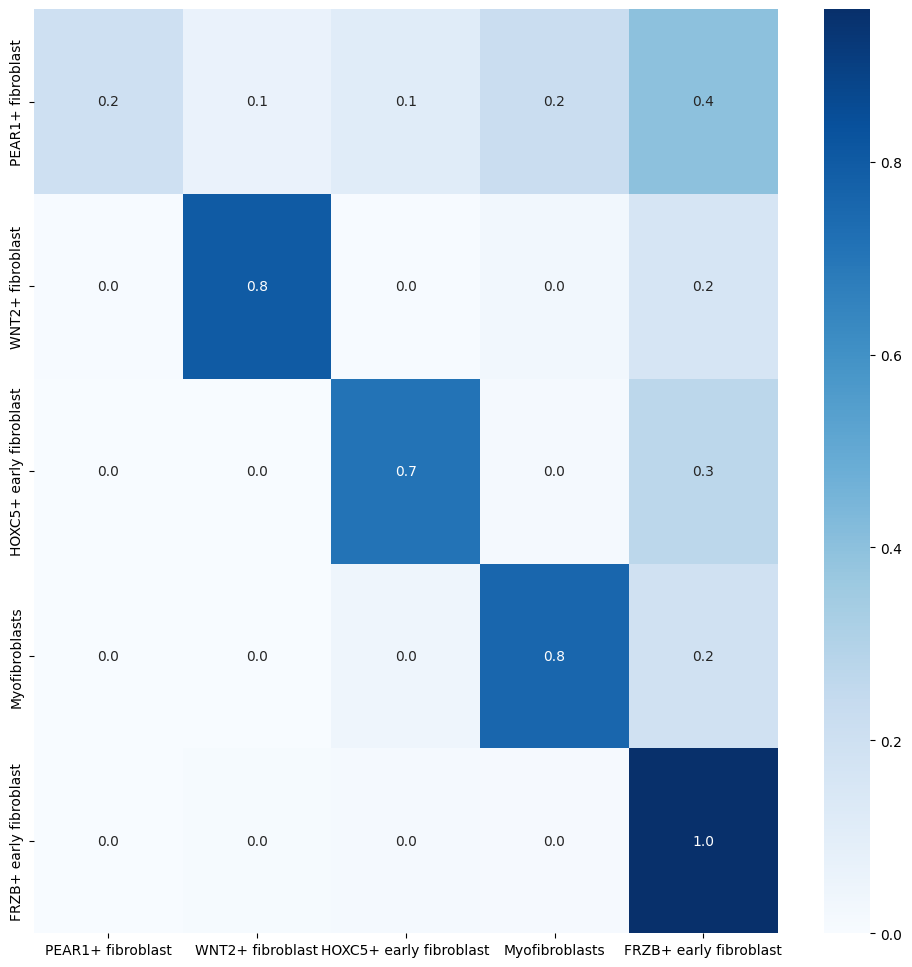

In [119]:
if final_task == "evaluation":
    from sklearn.metrics import confusion_matrix
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    set_predicted_cell_types = list(adata_unseen.obs[ref_meta_colname].unique())
    for i in set(y_pred_unseen):
        if i not in set_predicted_cell_types:
            set_predicted_cell_types.remove(i)

    cm = confusion_matrix(y_true_unseen, y_pred_unseen)
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    cm = pd.DataFrame(cm, index=set_predicted_cell_types[:cm.shape[0]], columns=set_predicted_cell_types[:cm.shape[1]])
    plt.figure(figsize=(12, 12))
    sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues")

In [130]:
# Ensure that .X contains only the genes used in training
training_genes = adata.var_names  # from your training AnnData object
target_genes = adata_target.var_names # all genes available in the raw slot

# Find overlap
common_genes = training_genes.intersection(target_genes)

# Subset target to training genes (keeping order consistent)
#adata_unseen = adata_unseen.to_adata()  # convert raw into an AnnData
#adata_unseen = adata_unseen[:, training_genes].copy()

# print(adata_unseen.shape)  # should be (n_cells, 2000)

In [132]:
print(filename_target)
adata_target = sc.read_h5ad(filename_target)

250407_kr250331a_10k_integrated-cca.h5ad


In [135]:
print(adata_target.raw.X)

  (0, 30)	1.0
  (0, 38)	1.0
  (0, 69)	1.0
  (0, 180)	8.0
  (0, 194)	1.0
  (0, 218)	2.0
  (0, 221)	2.0
  (0, 230)	2.0
  (0, 259)	1.0
  (0, 303)	1.0
  (0, 374)	1.0
  (0, 425)	1.0
  (0, 430)	1.0
  (0, 458)	1.0
  (0, 464)	1.0
  (0, 495)	1.0
  (0, 500)	2.0
  (0, 519)	1.0
  (0, 535)	2.0
  (0, 551)	12.0
  (0, 557)	1.0
  (0, 562)	1.0
  (0, 581)	1.0
  (0, 588)	1.0
  (0, 594)	1.0
  :	:
  (14586, 38208)	1.0
  (14586, 38219)	2.0
  (14586, 38230)	1.0
  (14586, 38278)	1.0
  (14586, 38296)	1.0
  (14586, 38355)	3.0
  (14586, 38361)	4.0
  (14586, 38372)	1.0
  (14586, 38381)	1.0
  (14586, 38383)	1.0
  (14586, 38384)	29.0
  (14586, 38386)	1.0
  (14586, 38415)	1.0
  (14586, 38569)	5.0
  (14586, 38570)	2.0
  (14586, 38571)	30.0
  (14586, 38572)	42.0
  (14586, 38573)	1.0
  (14586, 38574)	23.0
  (14586, 38575)	41.0
  (14586, 38576)	19.0
  (14586, 38577)	1.0
  (14586, 38578)	9.0
  (14586, 38579)	2.0
  (14586, 38581)	8.0


In [136]:
print(adata_target.X)

  (0, 30)	1.1450836052969398
  (0, 38)	1.1450836052969398
  (0, 69)	1.1450836052969398
  (0, 180)	2.898209448382872
  (0, 194)	1.1450836052969398
  (0, 218)	1.6649498509905882
  (0, 221)	1.6649498509905882
  (0, 230)	1.6649498509905882
  (0, 259)	1.1450836052969398
  (0, 303)	1.1450836052969398
  (0, 374)	1.1450836052969398
  (0, 425)	1.1450836052969398
  (0, 430)	1.1450836052969398
  (0, 458)	1.1450836052969398
  (0, 464)	1.1450836052969398
  (0, 495)	1.1450836052969398
  (0, 500)	1.6649498509905882
  (0, 519)	1.1450836052969398
  (0, 535)	1.6649498509905882
  (0, 551)	3.2851297155719608
  (0, 557)	1.1450836052969398
  (0, 562)	1.1450836052969398
  (0, 581)	1.1450836052969398
  (0, 588)	1.1450836052969398
  (0, 594)	1.1450836052969398
  :	:
  (14586, 38208)	0.8532078843053583
  (14586, 38219)	1.3067987892043815
  (14586, 38230)	0.8532078843053583
  (14586, 38278)	0.8532078843053583
  (14586, 38296)	0.8532078843053583
  (14586, 38355)	1.6177022005285422
  (14586, 38361)	1.8545240549461

In [137]:
final_task = "target" # "evaluation" or "target"
if final_task == "target":
    print(filename_target)
    adata_target = sc.read_h5ad(filename_target)
    adata_target.X = adata_target.raw.X.copy()
    adata_target.var["gene_name"] = adata_target.var_names # "Data must have the provided key 'gene_name' in its 'var' section to be processed by the Helical RNA model."
elif final_task == "evaluation": 
    adata_unseen = adata_evaluation # AnnData preprocessing was done before the finetuning - evaluation split.
    

250407_kr250331a_10k_integrated-cca.h5ad


In [139]:
# Process the unseen data
if Normalize_SubsetHighlyVariable:
    data_processed = scgpt.process_data(adata_target, gene_names = "gene_name", fine_tuning=True)
else:
    data_processed = scgpt.process_data(adata_target, gene_names = "gene_name")

# Get embeddings and predictions
x_unseen = scgpt.get_embeddings(data_processed)
predictions_nn_unseen = head_model_scgpt(torch.Tensor(x_unseen))

INFO:helical.models.scgpt.model:Processing data for scGPT.
INFO:helical.models.scgpt.model:Filtering out 14108 genes to a total of 24498 genes with an ID in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Successfully processed the data for scGPT.
INFO:helical.models.scgpt.model:Started getting embeddings:
  torch.cuda.amp.autocast(enabled=True),

Embedding cells: 100%|██████████| 292/292 [02:09<00:00,  2.26it/s]
INFO:helical.models.scgpt.model:Finished getting embeddings.


In [ ]:
if final_task == "evaluation":
    y_pred_unseen = np.array(torch.argmax(predictions_nn_unseen, dim=1))
    y_true_unseen = np.array(adata_unseen.obs[ref_meta_colname].astype("category").cat.codes)
    get_evaluations("Unseen evaluation set", y_true_unseen, y_pred_unseen)
    plot.target_analysis(y_true_unseen)
    print(id2type)
elif final_task == "target":
    save_annData_with_predictions = True

    y_pred_unseen = [id2type[prediction] for prediction in np.array(torch.argmax(predictions_nn_unseen, dim=1))]
    if save_annData_with_predictions:
        adata_target.obs[predictions_meta_name] = y_pred_unseen
        adata_target.obs.to_csv(filename_out_predictions)

    print(adata_target.obs)


                   orig.ident  nCount_RNA  nFeature_RNA  nCount_HTO  \
AAACCCAAGCCGTAAG-1  KR250402A      4667.0          2003       967.0   
AAACGCTAGGAAGTCC-1  KR250402A      9009.0          2929      1323.0   
AAACGCTCACACAGAG-1  KR250402A     12307.0          3289      2376.0   
AAAGAACCACCACTGG-1  KR250402A     21826.0          5375      3992.0   
AAAGAACCAGAGGCAT-1  KR250402A     24863.0          5223      2039.0   
...                       ...         ...           ...         ...   
TTTGACTAGCTGACTT-1  KR250402A       519.0           407       361.0   
TTTGATCCACTCTAGA-1  KR250402A      5500.0          2085       580.0   
TTTGGTTCACCATTCC-1  KR250402A     15174.0          4536       962.0   
TTTGTTGCATGAGAAT-1  KR250402A     16762.0          4544      1945.0   
TTTGTTGGTAGACGGT-1  KR250402A      7423.0          2751      1143.0   

                    nFeature_HTO          HTO_maxID            HTO_secondID  \
AAACCCAAGCCGTAAG-1             9       Hker-primary      Kerat-054-b

  .groupby([sample_id, ref_meta_colname])

  .groupby(sample_id)

  .apply(lambda df: df.assign(freq=df["count"] / df["count"].sum()))



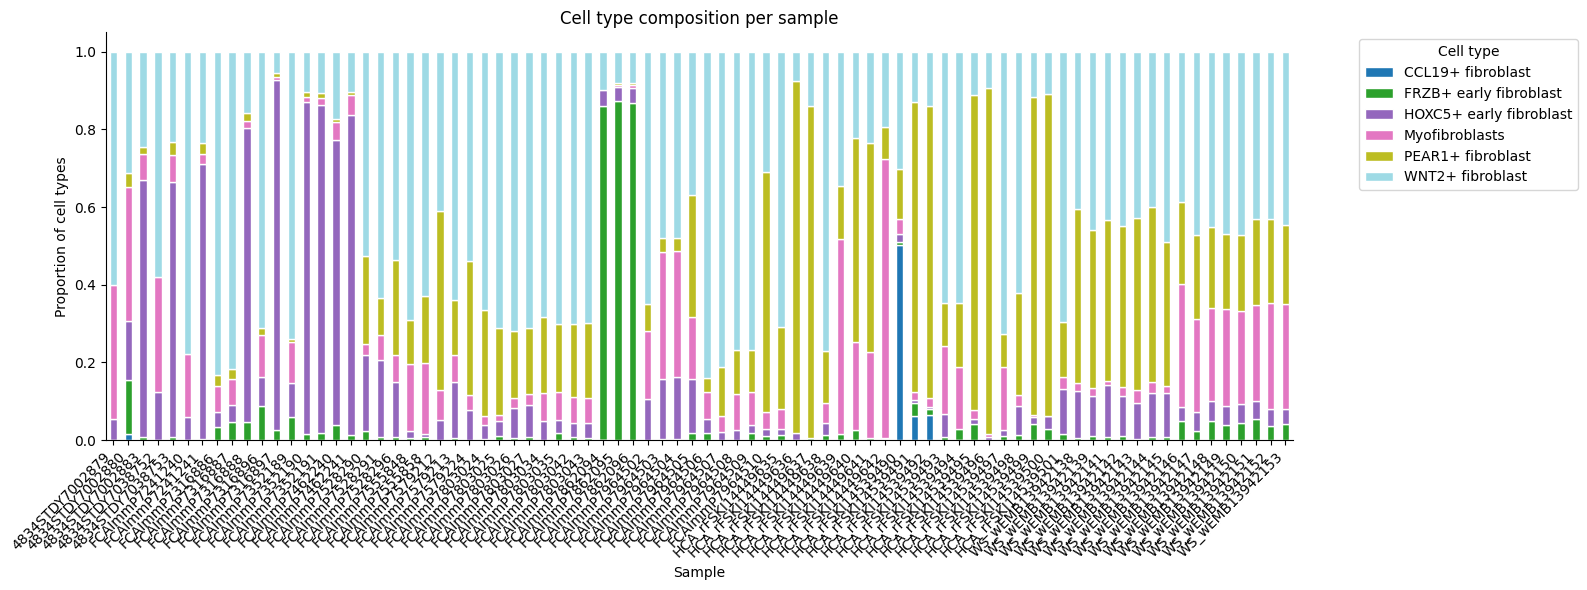

In [144]:
celltype_counts = (
    adata.obs
    .groupby([sample_id, ref_meta_colname])
    .size()
    .reset_index(name="count")
)
celltype_freq = (
    celltype_counts
    .groupby(sample_id)
    .apply(lambda df: df.assign(freq=df["count"] / df["count"].sum()))
    .reset_index(drop=True)
)
celltype_freq

import matplotlib.pyplot as plt
# pivot to have patients as rows and cell types as columns (proportions)
celltype_pivot = celltype_freq.pivot(index=sample_id,
                                     columns=ref_meta_colname,
                                     values="freq").fillna(0)
# stacked bar plot
celltype_pivot.plot(kind="bar",
                    stacked=True,
                    figsize=(16,6),
                    colormap="tab20")  # nice color palette
plt.ylabel("Proportion of cell types")
plt.xlabel("Sample")
plt.xticks(rotation=45, ha="right")
plt.title("Cell type composition per sample")
plt.legend(title="Cell type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [145]:
adata_target.obs

,orig.ident,nCount_RNA,nFeature_RNA,nCount_HTO,nFeature_HTO,HTO_maxID,HTO_secondID,HTO_margin,HTO_classification,HTO_classification.global,...,integrated_snn_res.0.2,integrated_snn_res.0.3,integrated_snn_res.0.4,integrated_snn_res.0.5,integrated_snn_res.0.6,integrated_snn_res.0.7,integrated_snn_res.0.8,active_ident_celltypes,total_counts,cell_type_predictions
AAACCCAAGCCGTAAG-1,KR250402A,4667.0,2003,967.0,9,Hker-primary,Kerat-054-batch-10,1.974654,Hker-primary,Singlet,...,0,0,0,0,0,0,0,0,4667.0,WNT2+ fibroblast
AAACGCTAGGAAGTCC-1,KR250402A,9009.0,2929,1323.0,9,Hker-primary,Kerat-099-batch-4,2.301621,Hker-primary,Singlet,...,0,0,0,0,0,0,0,0,9009.0,HOXC5+ early fibroblast
AAACGCTCACACAGAG-1,KR250402A,12307.0,3289,2376.0,9,Hker-primary,Kerat-2D,3.088346,Hker-primary,Singlet,...,0,0,0,0,0,2,2,2,12307.0,WNT2+ fibroblast
AAAGAACCACCACTGG-1,KR250402A,21826.0,5375,3992.0,9,Hker-primary,Kerat-054-batch-10,3.699248,Hker-primary,Singlet,...,0,0,0,0,0,0,0,0,21826.0,HOXC5+ early fibroblast
AAAGAACCAGAGGCAT-1,KR250402A,24863.0,5223,2039.0,9,Hker-primary,Kerat-XPC-D10-batch-11,3.140058,Hker-primary,Singlet,...,0,0,0,0,0,0,0,0,24863.0,HOXC5+ early fibroblast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGACTAGCTGACTT-1,KR250402A,519.0,407,361.0,9,Kerat-020-batch-9,Kerat-099-batch-14,0.359162,Kerat-020-batch-9,Singlet,...,4,3,3,3,4,4,4,4,519.0,HOXC5+ early fibroblast
TTTGATCCACTCTAGA-1,KR250402A,5500.0,2085,580.0,9,Kerat-020-batch-9,Kerat-054-batch-10,2.703640,Kerat-020-batch-9,Singlet,...,1,0,5,0,5,5,5,5,5500.0,WNT2+ fibroblast
TTTGGTTCACCATTCC-1,KR250402A,15174.0,4536,962.0,9,Kerat-020-batch-9,Kerat-XPC-D10-batch-11,3.709201,Kerat-020-batch-9,Singlet,...,0,0,0,0,0,0,0,0,15174.0,HOXC5+ early fibroblast
TTTGTTGCATGAGAAT-1,KR250402A,16762.0,4544,1945.0,9,Kerat-020-batch-9,Kerat-099-batch-4,4.470240,Kerat-020-batch-9,Singlet,...,2,1,1,1,1,1,1,1,16762.0,WNT2+ fibroblast


In [151]:
adata_target.obs[sample_id_target].unique

<bound method Series.unique of AAACCCAAGCCGTAAG-1         Hker-primary
AAACGCTAGGAAGTCC-1         Hker-primary
AAACGCTCACACAGAG-1         Hker-primary
AAAGAACCACCACTGG-1         Hker-primary
AAAGAACCAGAGGCAT-1         Hker-primary
                            ...        
TTTGACTAGCTGACTT-1    Kerat-020-batch-9
TTTGATCCACTCTAGA-1    Kerat-020-batch-9
TTTGGTTCACCATTCC-1    Kerat-020-batch-9
TTTGTTGCATGAGAAT-1    Kerat-020-batch-9
TTTGTTGGTAGACGGT-1    Kerat-020-batch-9
Name: HTO_maxID, Length: 14587, dtype: object>

In [164]:
n_unique_sampleids = adata_target.obs[sample_id_target].nunique()
print("Number of unique sample IDs:", n_unique_sampleids)

Number of unique sample IDs: 9


  .apply(lambda df: df.assign(freq=df["count"] / df["count"].sum()))



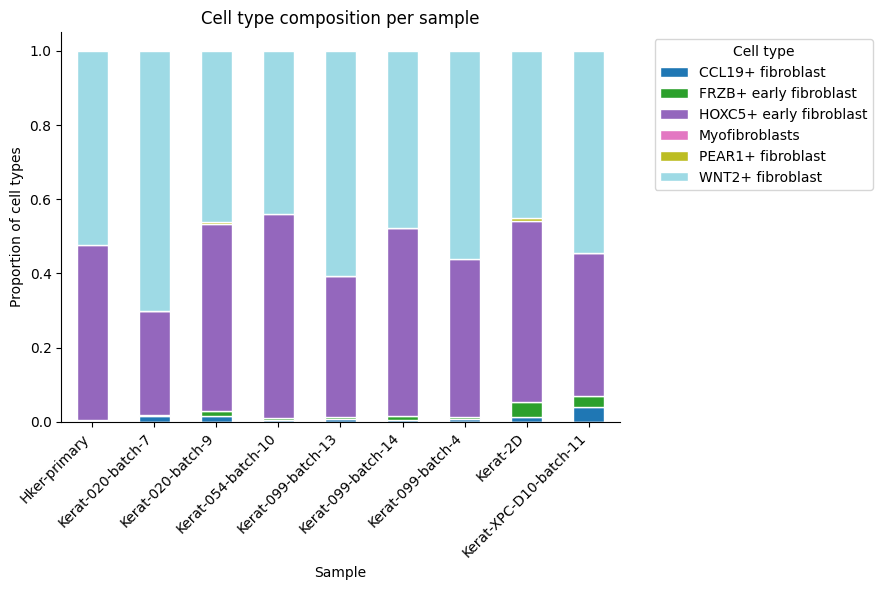

In [165]:
# Proportion of cell types per sample

celltype_counts = (
    adata_target.obs
    .groupby([sample_id_target, predictions_meta_name])
    .size()
    .reset_index(name="count")
)
celltype_freq = (
    celltype_counts
    .groupby(sample_id_target)
    .apply(lambda df: df.assign(freq=df["count"] / df["count"].sum()))
    .reset_index(drop=True)
)
celltype_freq

import matplotlib.pyplot as plt
# pivot to have patients as rows and cell types as columns (proportions)
celltype_pivot = celltype_freq.pivot(index=sample_id_target,
                                     columns=predictions_meta_name,
                                     values="freq").fillna(0)
# stacked bar plot
celltype_pivot.plot(kind="bar",
                    stacked=True,
                    figsize=(n_unique_sampleids,6),
                    colormap="tab20")  # nice color palette
plt.ylabel("Proportion of cell types")
plt.xlabel("Sample")
plt.xticks(rotation=45, ha="right")
plt.title("Cell type composition per sample")
plt.legend(title="Cell type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Geneformer

Let's do the same with the Geneformer.

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if 'rows' in adata.obs:
    adata_finetuning.obs['rows'] = adata_finetuning.obs['rows'].astype(str)
geneformer_config = GeneformerConfig(batch_size=50, device=device)
geneformer = Geneformer(configurer = geneformer_config)

data_geneformer = geneformer.process_data(adata_finetuning, gene_names = "gene_name")
x_geneformer = geneformer.get_embeddings(data_geneformer)
x_geneformer.shape

INFO:helical.models.geneformer.model:Model finished initializing.
INFO:helical.models.geneformer.model:'gf-12L-38M-i4096' model is in 'eval' mode, on device 'cuda' with embedding mode 'cell'.
INFO:helical.models.geneformer.model:Processing data for Geneformer.
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/sarper_unix/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/sarper_unix/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/sarper_unix/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle
INFO:helical.utils.mapping:Mapped 17555 genes to Ensembl IDs from a total of 28422 genes.
INFO:helical.models.geneformer.geneformer_tokenizer:AnnData object with n_obs × n_vars = 8024 × 28422
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.

(8024, 512)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(x_geneformer, y_encoded, test_size=0.1, random_state=42)

head_model_geneformer = deepcopy(head_model)
head_model_geneformer = train_model(head_model_geneformer,
                                    torch.tensor(X_train),
                                    y_train,
                                    torch.tensor(X_test),
                                    y_test,
                                    optim.Adam(head_model_geneformer.parameters(), lr=0.001),
                                    nn.CrossEntropyLoss())

Epoch 1, Validation Loss: 1.1014015491192157
Epoch 2, Validation Loss: 0.6333962816458482
Epoch 3, Validation Loss: 0.4886948512150691
Epoch 4, Validation Loss: 0.42000423257167524
Epoch 5, Validation Loss: 0.4195136519578787
Epoch 6, Validation Loss: 0.386587156699254
Epoch 7, Validation Loss: 0.3638423681259155
Epoch 8, Validation Loss: 0.36238491993684036
Epoch 9, Validation Loss: 0.3416837728940524
Epoch 10, Validation Loss: 0.34537209341159236
Epoch 11, Validation Loss: 0.33101881123506105
Epoch 12, Validation Loss: 0.32591029887016004
Epoch 13, Validation Loss: 0.3346465229988098
Epoch 14, Validation Loss: 0.3153350674189054
Epoch 15, Validation Loss: 0.31784011882085067
Epoch 16, Validation Loss: 0.3035476127496132
Epoch 17, Validation Loss: 0.3121848782667747
Epoch 18, Validation Loss: 0.2905778896350127
Epoch 19, Validation Loss: 0.30400814574498397
Epoch 20, Validation Loss: 0.3133898251331769
Epoch 21, Validation Loss: 0.3093366130040242
Epoch 22, Validation Loss: 0.29343259

In [32]:
data_unseen_geneformer = geneformer.process_data(adata_unseen, gene_names = "gene_name")
x_unseen_geneformer = geneformer.get_embeddings(data_unseen_geneformer)
predictions_nn_unseen_geneformer = head_model_geneformer(torch.Tensor(x_unseen_geneformer))

INFO:helical.models.geneformer.model:Processing data for Geneformer.
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/sarper_unix/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/sarper_unix/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/sarper_unix/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle
INFO:helical.utils.mapping:Mapped 17555 genes to Ensembl IDs from a total of 28422 genes.
INFO:helical.models.geneformer.geneformer_tokenizer:AnnData object with n_obs × n_vars = 2715 × 28422
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'RNA_snn_res.1', 'seurat_clusters', 'pANN_0.25_0.26_905', 'DF.classifications_0.25_0.26_905', 'pANN_0.25_0.26_1131', 'DF.classifications_0.25_0.2

In [38]:
y_true_unseen = np.array(adata_unseen.obs["LVL1"].tolist())
y_pred_unseen = [id2type[prediction] for prediction in np.array(torch.argmax(predictions_nn_unseen_geneformer, dim=1))]

geneformer_results = get_evaluations("Evaluation set", y_true_unseen, y_pred_unseen)

Evaluation set accuracy: 99.2%
Evaluation set precision: 89.5%
Evaluation set f1: 84.1%
Evaluation set recall: 82.0%


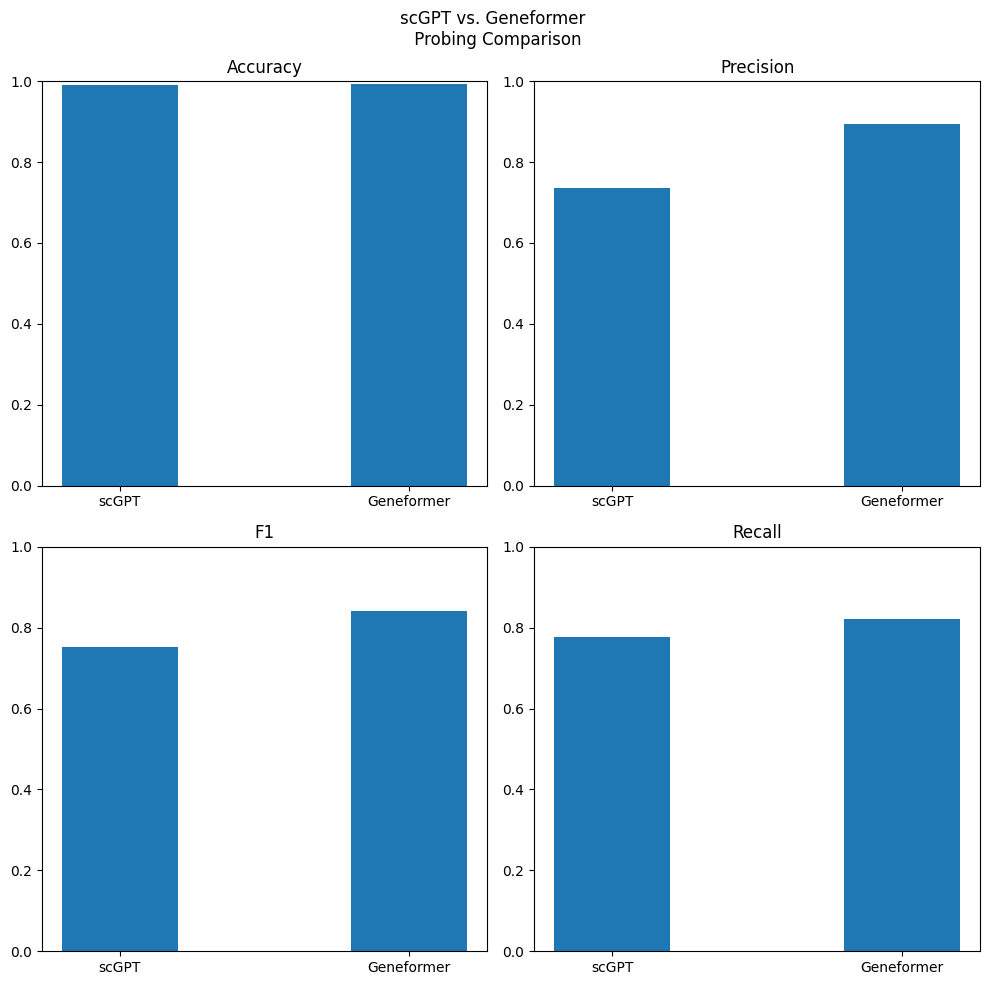

In [39]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

values_1 = [scgpt_results["accuracy"], geneformer_results["accuracy"]]
x = ["scGPT", "Geneformer"]
axs[0, 0].bar(x, values_1, width=0.4)
axs[0, 0].set_title("Accuracy")
axs[0, 0].set_ylim([0, 1])

values_2 = [scgpt_results["precision"], geneformer_results["precision"]]
axs[0, 1].bar(x, values_2, width=0.4)
axs[0, 1].set_title("Precision")
axs[0, 1].set_ylim([0, 1])

values_3 = [scgpt_results["f1"], geneformer_results["f1"]]
axs[1, 0].bar(x, values_3, width=0.4)
axs[1, 0].set_title("F1")
axs[1, 0].set_ylim([0, 1])

values_4 = [scgpt_results["recall"], geneformer_results["recall"]]
axs[1, 1].bar(x, values_4, width=0.4)
axs[1, 1].set_title("Recall")
axs[1, 1].set_ylim([0, 1])

fig.suptitle("scGPT vs. Geneformer \n Probing Comparison")
fig.tight_layout()
plt.show()



## scGPT
- Accuracy: 99.2%
- Precision: 90.8%
- Recall: 79.1%
- Macro F1: 80.7%

## Geneformer
- Accuracy: 98.9%
- Precision: 71.6%
- Recall: 73.6%
- Macro F1: 77.3%

 (c) Helical 2024 - Developed by the Helical Team